In [1]:
import sys
!{sys.executable} -m pip install rake_nltk
!{sys.executable} -m pip install yake
!{sys.executable} -m spacy download en_core_web_lg 

     |████████████████████████████████| 1.5 MB 38.1 MB/s 
     |████████████████████████████████| 749 kB 48.6 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
     |████████████████████████████████| 60 kB 8.7 MB/s 
     |████████████████████████████████| 137 kB 52.9 MB/s 
  Created wheel for jellyfish: filename=jellyfish-0.8.9-cp37-cp37m-linux_x86_64.whl size=73237 sha256=3964912fa328edbdfe5320377bc8f67bd9760dd004afcebedd3aa63d59b1431b
  Stored in directory: /root/.cache/pip/wheels/32/a9/ef/5d8742e72deaf0d1de327a180d008c2c0299367581800ea73f
  Created wheel for segtok: filename=segtok-1.5.10-py3-none-any.whl size=25030 sha256=6a2dc21d12ae9af7d5a18cd99ccc532860370c142d7ce3c281ab7284e5feaf27
  Stored in directory: /root/.cache/pi

In [55]:
import pandas as pd
import re
import math
import spacy
import string
import numpy as np
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from rake_nltk import Rake
from yake.highlight import TextHighlighter
from nltk import ngrams
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("Course Descriptions - Tabellenblatt2.csv")

In [5]:
def preprocess_text(narrative):
    narrative = narrative.translate(str.maketrans('', '', string.punctuation))
    _RE_COMBINE_WHITESPACE = re.compile(r"\s+")
    narrative = _RE_COMBINE_WHITESPACE.sub(" ", narrative).strip()
    narrative = narrative.lower()
    return narrative

In [6]:
def handle_punctuation(text):
    return re.sub(r'(?<=[?.,!")])(?=[^\s])', r' ', text)



In [7]:
def get_number_unique_words(narratives):
    count_vectorizer = CountVectorizer()
    X = count_vectorizer.fit_transform(narratives)
    return len(count_vectorizer.get_feature_names())

In [8]:
def highlight_keywords(text):
    r = Rake()
    r.extract_keywords_from_text(text)
    keywords_rake = r.get_ranked_phrases_with_scores()[:10]
    keywords_rake_reversed = []
    for ituple in keywords_rake:
        keywords_rake_reversed.append(tuple(reversed(ituple)))
    th_rake = TextHighlighter(max_ngram_size = 7, highlight_pre = "<code style=background:yellow;color:black>", highlight_post= "</code>")
    return th_rake.highlight(text, keywords_rake_reversed)

In [28]:
df

,University,Course Title,Short Description,Syllabus,Credits,Syllabus_punct,Processed_Syllabus
0,University of British Columbia,Porgramming for Data Science,Program design and data manipulation with Pyth...,Pseudo-code. Program design and structure. Flo...,1.0,Pseudo-code. Program design and structure. Flo...,pseudo code program design structure flow cont...
1,University of British Columbia,Computing Platforms for Data Science,"How to install, maintain, and use the data sci...","ntroduction to software, shells, tools, and fi...",1.0,"ntroduction to software, shells, tools, and fi...",ntroduction software shell tool file system us...
2,University of British Columbia,Programming for Data Manipulation,Program design and data manipulation with R. O...,Program design and data manipulation using ind...,1.0,Program design and data manipulation using ind...,program design datum manipulation use industry...
3,University of British Columbia,Fundamental concepts in probability including ...,Fundamental concepts in probability including ...,Descriptive statistics including measures of l...,1.0,Descriptive statistics including measures of l...,descriptive statistic include measure location...
4,University of British Columbia,Algorithms and Data Structures,How to choose and use appropriate algorithms a...,Basic algorithms. Recursion. Data structures i...,1.0,Basic algorithms. Recursion. Data structures i...,basic algorithm recursion data structure inclu...
...,...,...,...,...,...,...,...
296,University of Texas,Demand Analytics/Pricing,"Strategic problems, policies, models, and conc...","Strategic problems, policies, models, and conc...",3.0,"Strategic problems, policies, models, and conc...",strategic problem policy model concept design ...
297,University of Texas,Advanced Data Analytics in Marketing,Introduction to the data and tools used to ana...,Introduction to the data and tools used to ana...,3.0,Introduction to the data and tools used to ana...,introduction datum tool use analyze business e...
298,University of Texas,Financia Technology,The course provides an overview of the most re...,how new technologies create value in the finan...,2.0,how new technologies create value in the finan...,new technology create value financial industry...
299,University of Texas,Healthcare Analytics,Federal and state legislatures' efforts to rei...,Federal and state legislatures' efforts to rei...,3.0,Federal and state legislatures' efforts to rei...,federal state legislature effort reign health ...


In [10]:
df.dropna(axis=0)

,University,Course Title,Short Description,Syllabus,Credits
0,University of British Columbia,Porgramming for Data Science,Program design and data manipulation with Pyth...,Pseudo-code. Program design and structure. Flo...,1.0
1,University of British Columbia,Computing Platforms for Data Science,"How to install, maintain, and use the data sci...","ntroduction to software, shells, tools, and fi...",1.0
2,University of British Columbia,Programming for Data Manipulation,Program design and data manipulation with R. O...,Program design and data manipulation using ind...,1.0
3,University of British Columbia,Fundamental concepts in probability including ...,Fundamental concepts in probability including ...,Descriptive statistics including measures of l...,1.0
4,University of British Columbia,Algorithms and Data Structures,How to choose and use appropriate algorithms a...,Basic algorithms. Recursion. Data structures i...,1.0
...,...,...,...,...,...
296,University of Texas,Demand Analytics/Pricing,"Strategic problems, policies, models, and conc...","Strategic problems, policies, models, and conc...",3.0
297,University of Texas,Advanced Data Analytics in Marketing,Introduction to the data and tools used to ana...,Introduction to the data and tools used to ana...,3.0
298,University of Texas,Financia Technology,The course provides an overview of the most re...,how new technologies create value in the finan...,2.0
299,University of Texas,Healthcare Analytics,Federal and state legislatures' efforts to rei...,Federal and state legislatures' efforts to rei...,3.0


In [69]:
df["Syllabus_punct"] =df["Syllabus"]
#df["Syllabus_kw"] = df["Syllabus"].apply(highlight_keywords)
df["Syllabus_punct"] = df["Syllabus_punct"].astype(str).apply(handle_punctuation)
df["Description_punct"]=df["Short Description"].astype(str).apply(handle_punctuation)
#df["Syllabus_punct"] = df["Narrative_punct"].apply(preprocess_text)
syllabi = [syllabus for syllabus in df.loc[:, "Syllabus_punct"]] 
descriptions = [description for description in df.loc[:, "Description_punct"]] 

In [13]:
type(df["Syllabus"][1])

str

In [14]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [15]:
nlp.disable_pipes('ner')
print(nlp.pipe_names)

['tagger', 'parser']


In [20]:
def spacy_tokenizer(tex):
    tokens = nlp(tex)
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
    tokens = [word for word in tokens if word not in stopwords and word not in punctuations]
    tokens = " ".join([token for token in tokens])
    return tokens

In [21]:
stopwords = list(STOP_WORDS)
punctuations = string.punctuation

In [67]:
df["Processed_Syllabus"] = df["Syllabus_punct"].apply(spacy_tokenizer)
df["Processed_Description"]=df["Description_punct"].apply(spacy_tokenizer)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, max_features):    
    vectorizer = TfidfVectorizer(max_features = max_features)
    X = vectorizer.fit_transform(text)
    return X

In [31]:
text = df["Processed_Syllabus"].values
# max features is the maximum number of unique words out of all of narratives
max_features = get_number_unique_words(syllabi)

X = vectorize(text, max_features)

In [32]:
from math import floor, sqrt
num_posts = X.shape[0]
number_clusters = floor(sqrt(num_posts))

In [33]:
!{sys.executable} -m pip install umap-learn

     |████████████████████████████████| 86 kB 5.5 MB/s 
     |████████████████████████████████| 1.1 MB 31.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=7987d4e071664c8f9ce684023f92258ce4d313d40f5fc7acfd147ab398fcc4da
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=2e4aeb165deece202448bdc3ee256332c4a16d0847c2298dab9344dd9272e5f8
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [72]:
import umap
import umap.umap_ as umap

umap_embeddings = umap.UMAP(n_neighbors = 15, 
                            n_components = 5,
                            min_dist=0.0,
                            metric='cosine').fit_transform(X)

In [35]:
!{sys.executable} -m pip install hdbscan

     |████████████████████████████████| 6.4 MB 26.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311893 sha256=e3d6d0dd9ed76ef7151184ec56965fb67198f262b0efbcd003a0bceeade8eed5
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan


In [36]:
import hdbscan
cluster = hdbscan.HDBSCAN(metric = 'euclidean',
                          min_cluster_size = 10,
                          cluster_selection_method='eom').fit(umap_embeddings)  

In [40]:
clusters = cluster.labels_.tolist()

In [41]:
y_pred = np.array(clusters) 

In [44]:
frame = df

In [46]:
frame ["Clusters"]=clusters

In [49]:
no_clusters = len(set(frame.Clusters))

In [52]:
from sklearn.manifold import TSNE

In [53]:
tsne = TSNE(verbose = 1, perplexity = 50)  
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 301 samples in 0.005s...
[t-SNE] Computed neighbors for 301 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 301 / 301
[t-SNE] Mean sigma: 0.319876
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.140575
[t-SNE] KL divergence after 1000 iterations: 0.916269


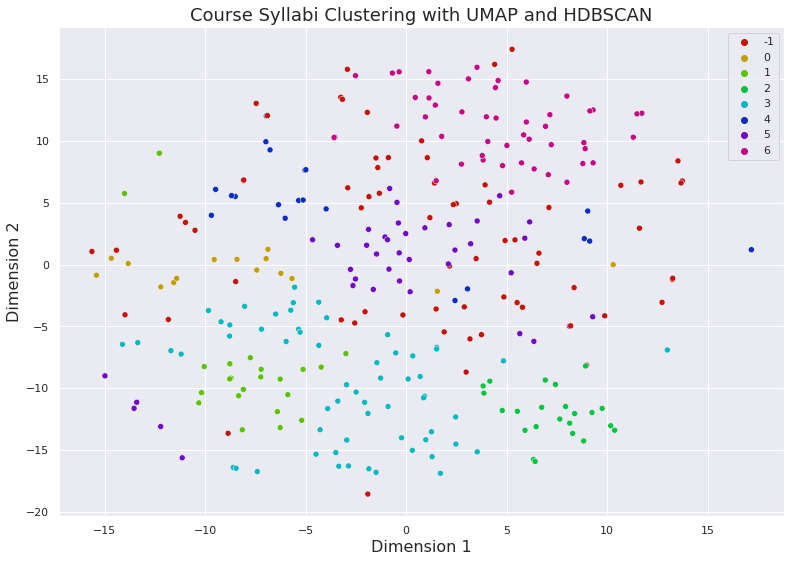

In [57]:
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(no_clusters, l=.4, s=.9)

# plot
sns_plot = sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue = y_pred, legend = 'full', palette = palette)
plt.title('Course Syllabi Clustering with UMAP and HDBSCAN', fontsize = 18)
plt.xlabel('Dimension 1', fontsize = 16)
plt.ylabel('Dimension 2', fontsize = 16)
plt.show()
fig = sns_plot.get_figure()
fig.savefig('output.png')

In [113]:
filtr = (frame["Clusters"] == 6)
smokefra = frame.loc[filtr].copy()

In [116]:
smokefra.shape

(49, 11)

In [115]:
smokefra["Course Title"].tolist()

['Fundamental concepts in probability including conditional, joint, and marginal distributions. Statistical view of data coming from a probability distribution.',
 'Statistical Inference and Computation I',
 'Regression II',
 'Statistical Inference and Computation II',
 'Spatial and Temporal Models',
 'Predictive Modelling',
 'Resampling and Regularization',
 'Web and Cloud Computing',
 'Supervised Learning',
 'Modelling and Simulation II',
 'Advanced Predictive Modelling',
 'Computational Inference',
 'Discrete Stochastic Models',
 'Fundamentals of Modelling',
 'Natural Language Processing',
 'Statistical Modelling II',
 'Statistical Modelling',
 'Decision Analysis',
 'Forecasting Methods',
 'Advanced Statistical Learning',
 'Statistical Learning',
 'Advanced Generalized Linear Models',
 'Causal Inference in Biostatistics',
 'Sampling Theory and Application',
 'Regression and ANOVA',
 'Intro to time Series Analysis',
 'Computation Intensive Stats',
 'Time Series Analysis',
 'Introduct

In [71]:
text = df["Processed_Description"].values
# max features is the maximum number of unique words out of all of narratives
max_features = get_number_unique_words(descriptions)

X = vectorize(text, max_features)

In [73]:
umap_embeddings = umap.UMAP(n_neighbors = 15, 
                            n_components = 5,
                            min_dist=0.0,
                            metric='cosine').fit_transform(X)

In [74]:
cluster = hdbscan.HDBSCAN(metric = 'euclidean',
                          min_cluster_size = 10,
                          cluster_selection_method='eom').fit(umap_embeddings)  

In [75]:
clusters = cluster.labels_.tolist()

In [76]:
frame ["Cluster"]=clusters

In [77]:
no_clusters = len(set(frame.Cluster))

In [78]:
y_pred = np.array(clusters) 

In [79]:
tsne = TSNE(verbose = 1, perplexity = 50)  
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 301 samples in 0.001s...
[t-SNE] Computed neighbors for 301 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 301 / 301
[t-SNE] Mean sigma: 0.307187
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.839134
[t-SNE] KL divergence after 1000 iterations: 0.946650


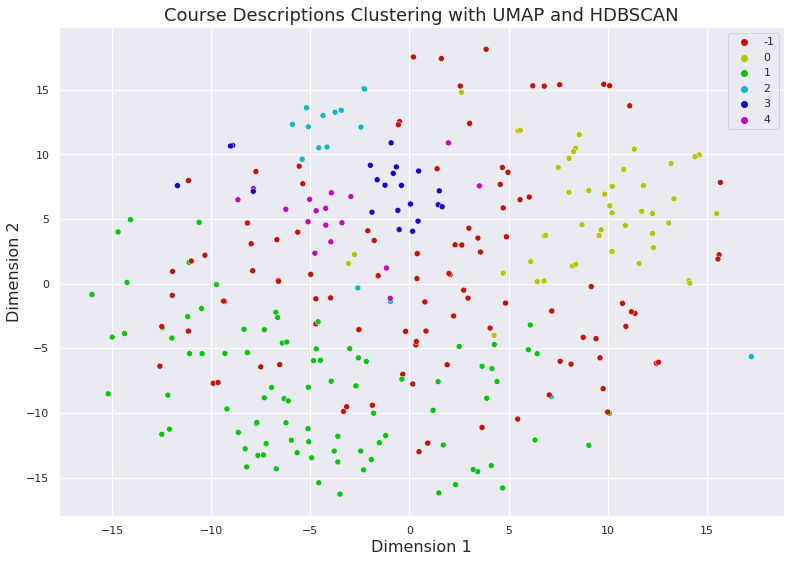

In [81]:
# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(no_clusters, l=.4, s=.9)

# plot
sns_plot = sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue = y_pred, legend = 'full', palette = palette)
plt.title('Course Descriptions Clustering with UMAP and HDBSCAN', fontsize = 18)
plt.xlabel('Dimension 1', fontsize = 16)
plt.ylabel('Dimension 2', fontsize = 16)
plt.show()
fig = sns_plot.get_figure()
fig.savefig('output.png')

In [82]:
filtr = (frame["Cluster"] == 2)
smokeframe = frame.loc[filtr].copy()

In [83]:
smokeframe

,University,Course Title,Short Description,Syllabus,Credits,Syllabus_punct,Processed_Syllabus,Clusters,Description_punct,Processed_Description,Cluster
55,University of British Columbia Okanagan,Optimization,Modeling using mathematical programming. Key c...,Modelling using mathematical programming. Fund...,1.0,Modelling using mathematical programming. Fund...,model use mathematical programming fundamental...,4,Modeling using mathematical programming. Key c...,model use mathematical programming key concept...,2
68,University of Waterloo,Fundamentals of Optimization,This course serves as a graduate level introdu...,"Linear optimization: Farkas' Lemma, duality, S...",0.0,"Linear optimization: Farkas' Lemma, duality, S...",linear optimization farkas lemma duality simpl...,4,This course serves as a graduate level introdu...,course serve graduate level introduction optim...,2
69,University of Waterloo,Optimization for Data Science,The course will cover optimization techniques ...,Convex sets and functions Gradient descent Pro...,0.0,Convex sets and functions Gradient descent Pro...,convex set function gradient descent projectio...,4,The course will cover optimization techniques ...,course cover optimization technique use especi...,2
70,University of Waterloo,Combinatorial Optimization,Characterizations of optimalsolutions and effi...,Spanning trees Maximum flows and minimum cuts ...,0.0,Spanning trees Maximum flows and minimum cuts ...,span tree maximum flow minimum cut matching ge...,4,Characterizations of optimalsolutions and effi...,characterization optimalsolution efficient alg...,2
71,University of Waterloo,Convex Optimization and Analysis,An introduction to the modern theory of convex...,"Introduction, Convex sets convex hulls Extreme...",0.0,"Introduction, Convex sets convex hulls Extreme...",introduction convex set convex hull extreme po...,4,An introduction to the modern theory of convex...,introduction modern theory convex programming ...,2
84,Carleton University,Optimization for Engineering Application,Introduction to algorithms and computer method...,Introduction to algorithms and computer method...,0.5,Introduction to algorithms and computer method...,introduction algorithm computer method optimiz...,4,Introduction to algorithms and computer method...,introduction algorithm computer method optimiz...,2
105,Ryerson,Optimization Models,This course is intended to give a broad treatm...,Emphasis will be given to understanding the mo...,1.0,Emphasis will be given to understanding the mo...,emphasis understand motivation scope optimizat...,4,This course is intended to give a broad treatm...,course intend broad treatment subject practica...,2
127,Simon Fraser,Design and Analysis of Algortithms,The objective of this course is to expose stud...,"Greedy Algorithms, Divide and Conquer, Dynamic...",3.0,"Greedy Algorithms, Divide and Conquer, Dynamic...",greedy algorithms divide conquer dynamic progr...,4,The objective of this course is to expose stud...,objective course expose student basic techniqu...,2
149,HEC Montreal,Fundamentals of Optimization,Knowledge of the basic optimization techniques...,linear programming non-linear programming inte...,3.0,linear programming non-linear programming inte...,linear programming non linear programming inte...,4,Knowledge of the basic optimization techniques...,knowledge basic optimization technique main co...,2
177,MIT,Optimization Methods,Introduces the principal algorithms for linear...,Linear optimization Robust optimization Networ...,12.0,Linear optimization Robust optimization Networ...,linear optimization robust optimization networ...,4,Introduces the principal algorithms for linear...,introduce principal algorithm linear network d...,2


In [117]:
processed = df["Processed_Description"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 2))
ngram_counts.most_common(10)

[(('machine', 'learning'), 51),
 (('neural', 'network'), 27),
 (('e.', 'g.'), 24),
 (('deep', 'learning'), 21),
 (('datum', 'science'), 20),
 (('natural', 'language'), 20),
 (('topic', 'include'), 19),
 (('introduce', 'student'), 15),
 (('data', 'set'), 14),
 (('datum', 'mining'), 14)]

In [118]:
processed = df["Processed_Description"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 3))
ngram_counts.most_common(10)

[(('database', 'management', 'system'), 9),
 (('natural', 'language', 'processing'), 8),
 (('large', 'data', 'set'), 7),
 (('course', 'introduce', 'student'), 7),
 (('high', 'dimensional', 'datum'), 5),
 (('support', 'vector', 'machine'), 5),
 (('linear', 'regression', 'model'), 4),
 (('key', 'concept', 'include'), 4),
 (('time', 'series', 'model'), 4),
 (('topic', 'cover', 'include'), 4)]

In [119]:
processed = df["Processed_Description"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 1))
ngram_counts.most_common(10)

[(('datum',), 238),
 (('course',), 136),
 (('model',), 135),
 (('use',), 120),
 (('learning',), 120),
 (('system',), 118),
 (('student',), 111),
 (('include',), 99),
 (('design',), 94),
 (('method',), 94)]

In [121]:
processed = df["Processed_Syllabus"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(),2))
ngram_counts.most_common(10)

[(('machine', 'learning'), 28),
 (('neural', 'network'), 24),
 (('deep', 'learning'), 22),
 (('linear', 'regression'), 19),
 (('monte', 'carlo'), 17),
 (('machine', 'learn'), 15),
 (('natural', 'language'), 14),
 (('linear', 'model'), 13),
 (('logistic', 'regression'), 13),
 (('time', 'series'), 13)]

In [120]:
processed = df["Processed_Syllabus"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 1))
ngram_counts.most_common(10)

[(('model',), 189),
 (('datum',), 160),
 (('learning',), 114),
 (('method',), 106),
 (('data',), 97),
 (('use',), 88),
 (('analysis',), 85),
 (('design',), 82),
 (('regression',), 81),
 (('system',), 76)]

In [122]:
processed = df["Processed_Syllabus"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 3))
ngram_counts.most_common(10)

[(('markov', 'decision', 'process'), 6),
 (('support', 'vector', 'machine'), 5),
 (('hide', 'markov', 'model'), 5),
 (('database', 'management', 'system'), 5),
 (('natural', 'language', 'processing'), 5),
 (('non', 'parametric', 'regression'), 5),
 (('multiple', 'linear', 'regression'), 4),
 (('generalize', 'additive', 'model'), 4),
 (('large', 'data', 'set'), 4),
 (('time', 'series', 'model'), 4)]